*Brian Du, Eric Henriksson, Ignacio Galve*

# **Bag of Visual Words Image Classification - Week 2**
The purpose of this second session is to build on last week's Bag of Visual Words classifier and try to further improve its performance by introducing the **normalization/standardization** of descriptors, **SVM** as an alternative to k-NN, **spatial pyramids**, and **Fisher Vectors**. Adjustments of hyperparameters and the general evaluation of the system will this time be carried out with the support of **cross-validation**. Since **dense SIFT** proved to be superior to regular SIFT, the entire session will be using the former. This notebook details the different steps that have been followed to implement these concepts, showcasing results and providing relevant insights on these.


## **Initial Setup**
First of all, a working environment is set up via Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/M3_Project/BoW
#!ls

/content/drive/.shortcut-targets-by-id/1RkzdpxVDRI4IsesNu0YEdrp7_RhPNFi5/M3_Project/BoW


The 4.4.0.44 version of OpenCV, which includes SIFT, is installed if necessary.

In [3]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 1.4 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


All libraries to be used are imported.

In [4]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import random
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, scale
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.mixture import GaussianMixture
from sklearn.multiclass import OneVsRestClassifier
from tqdm.notebook import tqdm

plt.rcParams["figure.figsize"] = (20,8)

The training and testing image files provided for the assignment are all read.

In [5]:
base_path = '/content/drive/MyDrive/M3_Project/BoW/'

In [6]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

In [7]:
classes = np.unique(np.array(train_labels))

## **1. Preparing Descriptors with Dense SIFT**
Similar functions to the ones from last week's session are used to compute/load **dense SIFT descriptors** for a given scale and step.

In [8]:
def compute_dense_descriptors(scale, step, kind = 'train'):
  t_descriptors = []
  t_label_per_descriptor = []

  if kind == 'train':
    filenames = train_images_filenames
    labels = train_labels
  elif kind == 'test':
    filenames = test_images_filenames
    labels = test_labels

  for filename, labels in (zip(filenames, labels)):
      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
      image_kpts = []

      for y in range(scale // 2, gray.shape[1], scale + step):
        for x in range(scale // 2, gray.shape[0], scale + step):
          image_kpts.append(cv2.KeyPoint(x, y, float(scale)))

      kpt, des = cv2.SIFT_create().compute(gray, image_kpts)
      t_descriptors.append(des)
      t_label_per_descriptor.append(labels)

  descriptors = np.vstack(t_descriptors)
  return descriptors, t_descriptors

In [9]:
def load_dense_descriptors(scale = 3, step = 5, kind = 'train'):
  dense_desc_path = base_path + 'SIFT' + f'_{kind}_dense_descriptors_{scale}-{step}.pkl'
  dense_t_desc_path = base_path + 'SIFT' + f'_{kind}_dense_t_descriptors_{scale}-{step}.pkl'

  if os.path.exists(dense_desc_path) and os.path.exists(dense_t_desc_path):
      with open(dense_desc_path, 'rb') as reader:
          dense_descriptors = pickle.load(reader)
      with open(dense_t_desc_path, 'rb') as reader:
          dense_t_descriptors = pickle.load(reader)
  else:
      dense_descriptors, dense_t_descriptors = compute_dense_descriptors(scale, step, kind)
      with open(dense_desc_path, 'wb') as handle:
          pickle.dump(dense_descriptors, handle, protocol=pickle.HIGHEST_PROTOCOL)
      with open(dense_t_desc_path, 'wb') as handle:
          pickle.dump(dense_t_descriptors, handle, protocol=pickle.HIGHEST_PROTOCOL)
  return dense_descriptors, dense_t_descriptors

This time the step will be set at a value of 5px, and different scales ranging from 2 to 9 will be tested.

In [10]:
step = 5
scales = range(2, 10)

All descriptors that are not already saved are computed for the specified step and scales using the presented functions.

In [ ]:
for scale in scales:
  dense_desc_path = base_path + 'SIFT' + f'_train_dense_descriptors_{scale}-{step}.pkl'
  dense_train_desc_path = base_path + 'SIFT' + f'_train_dense_t_descriptors_{scale}-{step}.pkl'

  if not os.path.exists(dense_desc_path):
    load_dense_descriptors(scale, step)
  print(f'Done computing/loading scale {scale}')

Done computing/loading scale 2
Done computing/loading scale 3
Done computing/loading scale 4
Done computing/loading scale 5
Done computing/loading scale 6
Done computing/loading scale 7
Done computing/loading scale 8
Done computing/loading scale 9


## **2. Normalization/Standardization of Descriptors**
The effects of **normalizing** and **standardizing** descriptors on the accuracy of the classifiers to be constructed is to be evaluated. These should in principle help avoid having the influence of some dimensions prevail over that of others by bringing all of them to a common scale.

A function is created to carry out a given kind of normalization/standardization (established by the argument *normalizer*) on the descriptors. These methods are taken directly from *sklearn*'s preprocessing library.

In [11]:
def normalize_vectors(data, train_data, normalizer):
  data_norm = normalizer.fit_transform(data)
  if train_data is not None:
    train_data_norm = list(map(lambda vec: normalizer.fit_transform(vec), train_data))
    return data_norm, train_data_norm
  else:
    return data_norm

Descriptors taken from the dense SIFT can thus be submitted to **L2 normalization** or **standard scaling** calling the functions below.

In [12]:
#L2 normalization
def l2_norm(dense_descriptors, dense_train_descriptors):
  return normalize_vectors(dense_descriptors, dense_train_descriptors, Normalizer(norm = 'l2'))

#Standard scaling
def stsc(dense_descriptors, dense_train_descriptors):
  return normalize_vectors(dense_descriptors, dense_train_descriptors, StandardScaler())

These kinds of normalization/standardization will be considered later on during testing.

## **3 Building BoVWs (Recap)**
This section just sets up the functions that take care of creating the BoVW. These were already seen in last week's session, and remain exactly the same.

The first is a function to carry out a k-means clustering on the descriptor space...

In [13]:
def kmean_clustering(descriptors, K):
  codebook = MiniBatchKMeans(n_clusters=K, verbose=False, batch_size=K * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
  codebook.fit(descriptors)
  return codebook

...and the second makes sure that for each training image descriptors are projected to their closest visual word of the corresponding codebook. Each image is thus represented as a histogram of counts for each visual word.

In [14]:
def compute_visual_words(input_desc, K, input_codebook):
  visual_words=np.zeros((len(input_desc), K), dtype=np.float32)
  for i in range(len(input_desc)):
      words=input_codebook.predict(input_desc[i])
      visual_words[i,:]=np.bincount(words,minlength = K)
  return visual_words

A function is also built to take in a classifier and a set of visual words so that the performance of the classifier can be compared to the ground truth established by the provided image labels.

In [15]:
def compute_accuracy(visual_words_test, classifier):
  accuracy = 100*classifier.score(visual_words_test, test_labels)
  return accuracy

## **4. Support Vector Machine (SVM)**
**SVM** is proposed as an alternative method for classification to the k-NN used until now. The codebook size is set to 128 for all of the testing in the following sections, according to last week's results. A function is also built to compute the accuracy of different kinds of SVM classifiers for different scales of the dense SIFT. The kind of kernel to be used, the regularization term C, and the kernel coefficient can be provided as inputs, as well as the type of normalization to be used (if any).

In [16]:
K = 128

In [17]:
def accuracies_rt_scales(kernel, C = 1, gamma = 'scale', norm = None, hint = False):
  accuracies = []

  if hint == True:
    kernel = 'hint'

  accuracies_path = base_path + f'accuracies_SVM_{kernel}_C{C}_gamma{gamma}_norm{norm}.pkl'
  if os.path.exists(accuracies_path):
    with open(accuracies_path, 'rb') as reader:
          accuracies = pickle.load(reader)
  else:
    for scale in scales:
      dense_descriptors, dense_t_descriptors = load_dense_descriptors(scale, step, 'train')
      dense_test_descriptors, dense_test_t_descriptors = load_dense_descriptors(scale, step, 'test')

      if norm == 'l2':
        dense_descriptors, dense_t_descriptors = l2_norm(dense_descriptors, dense_t_descriptors)
        dense_test_descriptors, dense_test_t_descriptors = l2_norm(dense_test_descriptors, dense_test_t_descriptors)
      elif norm == 'stsc':
        dense_descriptors, dense_t_descriptors = stsc(dense_descriptors, dense_t_descriptors)
        dense_test_descriptors, dense_test_t_descriptors = stsc(dense_test_descriptors, dense_test_t_descriptors)

      codebook = kmean_clustering(dense_descriptors, K)
      visual_words = compute_visual_words(dense_t_descriptors, K, codebook)
      visual_words_test = compute_visual_words(dense_test_t_descriptors, K, codebook)

      svm = SVC(kernel = kernel, C = C, gamma = gamma)
      svm.fit(visual_words, train_labels)

      accuracy = compute_accuracy(visual_words_test, svm)

      accuracies.append(accuracy)

    with open(accuracies_path, 'wb') as handle:
      pickle.dump(accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)
         
  return accuracies

### **4.1 SVM with Linear Kernel**
A preliminary SVM using a **linear kernel** and a **default** regularization of *C = 1* is first tested using the previous function.

In [ ]:
accuracies_linear_woutnorm = accuracies_rt_scales(kernel = 'linear', C = 1)

for i in range(len(scales)):
  print(f'Accuracy SVM linear kernel for C=1, scale: {scales[i]} (No normalization): {accuracies_linear_woutnorm[i]}')

Accuracy SVM linear kernel for C=1, scale: 2 (No normalization): 73.97769516728626
Accuracy SVM linear kernel for C=1, scale: 3 (No normalization): 76.2081784386617
Accuracy SVM linear kernel for C=1, scale: 4 (No normalization): 75.8364312267658
Accuracy SVM linear kernel for C=1, scale: 5 (No normalization): 78.81040892193309
Accuracy SVM linear kernel for C=1, scale: 6 (No normalization): 77.19950433705081
Accuracy SVM linear kernel for C=1, scale: 7 (No normalization): 76.95167286245353
Accuracy SVM linear kernel for C=1, scale: 8 (No normalization): 79.42998760842627
Accuracy SVM linear kernel for C=1, scale: 9 (No normalization): 77.32342007434944


Based on the results above, it is apparent how the SVM classifier delivers a decent accuracy without having fine-tuned the parameters or having done any normalization to the descriptors at all. Descriptors computed with a dense SIFT of scale 8 seem to lead to the highest accuracy, but there is no clear progression between scales that can confirm that one scale performs better than the other.

It is also tested how this accuracy changes when applying L2 normalization and standard scaling to the descriptors before running the classifier.

In [ ]:
accuracies_linear_l2 = accuracies_rt_scales(kernel = 'linear', C = 1, norm = 'l2')

for i in range(len(scales)):
  print(f'Accuracy SVM linear kernel for C=1, scale: {scales[i]} (L2 normalization): {accuracies_linear_l2[i]}')

Accuracy SVM linear kernel for C=1, scale: 2 (L2 normalization): 73.85377942998761
Accuracy SVM linear kernel for C=1, scale: 3 (L2 normalization): 75.96034696406444
Accuracy SVM linear kernel for C=1, scale: 4 (L2 normalization): 77.69516728624535
Accuracy SVM linear kernel for C=1, scale: 5 (L2 normalization): 78.31474597273854
Accuracy SVM linear kernel for C=1, scale: 6 (L2 normalization): 77.69516728624535
Accuracy SVM linear kernel for C=1, scale: 7 (L2 normalization): 78.93432465923172
Accuracy SVM linear kernel for C=1, scale: 8 (L2 normalization): 79.5539033457249
Accuracy SVM linear kernel for C=1, scale: 9 (L2 normalization): 79.67781908302355


In [ ]:
accuracies_linear_stsc = accuracies_rt_scales(kernel = 'linear', C = 1, norm = 'stsc')

for i in range(len(scales)):
  print(f'Accuracy SVM linear kernel for C=1, scale: {scales[i]} (Standard scaling): {accuracies_linear_stsc[i]}')

Accuracy SVM linear kernel for C=1, scale: 2 (Standard scaling): 74.10161090458487
Accuracy SVM linear kernel for C=1, scale: 3 (Standard scaling): 73.35811648079306
Accuracy SVM linear kernel for C=1, scale: 4 (Standard scaling): 75.71251548946717
Accuracy SVM linear kernel for C=1, scale: 5 (Standard scaling): 75.96034696406444
Accuracy SVM linear kernel for C=1, scale: 6 (Standard scaling): 77.44733581164807
Accuracy SVM linear kernel for C=1, scale: 7 (Standard scaling): 75.09293680297398
Accuracy SVM linear kernel for C=1, scale: 8 (Standard scaling): 75.58859975216853
Accuracy SVM linear kernel for C=1, scale: 9 (Standard scaling): 76.45600991325898


The previous accuracy results for different scales and types of normalizations can be visualized in the line plot below.

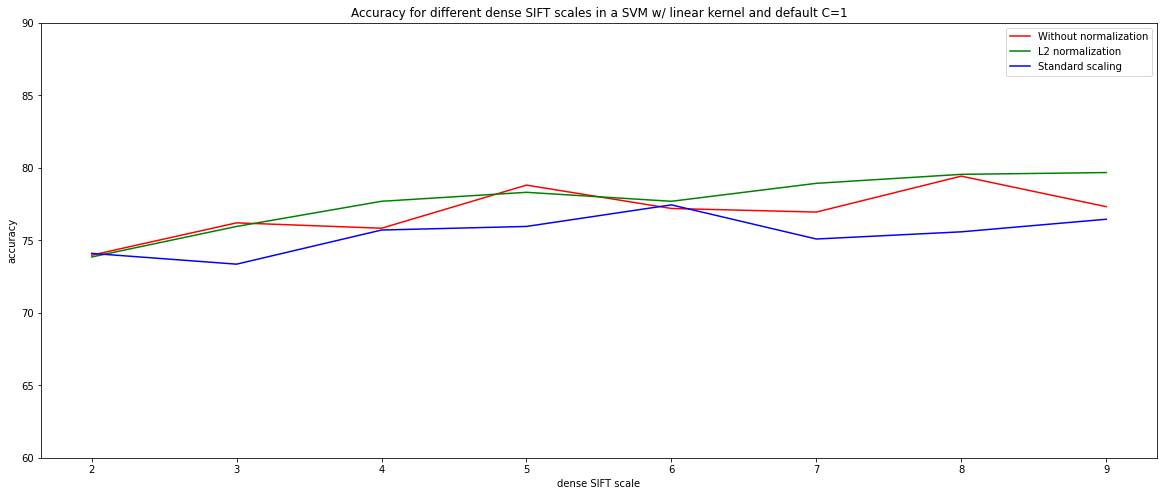

In [ ]:
scales_list = list(scales)
plt.title('Accuracy for different dense SIFT scales in a SVM w/ linear kernel and default C=1')
plt.plot(scales_list, accuracies_linear_woutnorm, 'r', label='Without normalization')
plt.plot(scales_list, accuracies_linear_l2, 'g', label='L2 normalization')
plt.plot(scales_list, accuracies_linear_stsc, 'b', label='Standard scaling')
plt.xlabel('dense SIFT scale')
plt.ylabel('accuracy')
plt.ylim([60, 90])
plt.legend()

plt.show()

There don't appear to be big differences in accuracy depending on whether normalization or standard scaling is applied or not. This small difference probably has to do with how all of the features in this particular case are already in a similar range that would not benefit from any further adjustments.

The scale used for the dense SIFT does not seem to have a great influence on the performance either; only a very subtle increase in accuracy can be appreciated as scale grows. A scale of 6 is fixed for the rest of this section, as well as standard scaling for the descriptors (which is common practice for SVMs).

Next, the idea is to use **(5-fold) cross-validation** in a **grid search** to optimize the regularization term shown in the *param_grid* below and hopefully maximize the classifiers accuracy at the specified scale.

In [ ]:
param_grid = [
  {'C': [0.00001, 0.0001, 0.001, 0.01, 0.5, 1.0, 10, 100]}
]

In [ ]:
dense_descriptors, dense_t_descriptors = load_dense_descriptors(6, step, 'train')
dense_descriptors_stsc, dense_t_descriptors_stsc = stsc(dense_descriptors, dense_t_descriptors)
codebook_stsc = kmean_clustering(dense_descriptors_stsc, K)
visual_words_stsc = compute_visual_words(dense_t_descriptors_stsc, K, codebook_stsc)

optim_param_path = base_path + f'optimal_param_lin_stsc_6_{step}.pkl'

if os.path.exists(optim_param_path):
    with open(optim_param_path, 'rb') as reader:
        optim_param = pickle.load(reader)
else:
    optim_param = GridSearchCV(
      SVC(kernel='linear'),
      param_grid,
      cv=5,
      scoring='accuracy'
    )
    optim_param.fit(visual_words_stsc, train_labels)
    with open(optim_param_path, 'wb') as handle:
        pickle.dump(optim_param, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f'Best parameters: {optim_param.best_params_}')

Best parameters: {'C': 0.0001}


The optimal regularization term turns out to be *C = 0.0001*. The accuracy of the classifier is thus recalculated for this new adjusted *C*, and the average score of the cross-validation is also computed.

In [ ]:
lin_svm_stsc_opt = SVC(C = 0.0001, kernel = 'linear')
lin_svm_stsc_opt.fit(visual_words_stsc, train_labels)

dense_test_descriptors, dense_test_t_descriptors = load_dense_descriptors(6, step, 'test')
dense_test_descriptors_stsc, dense_test_t_descriptors_stsc = stsc(dense_test_descriptors, dense_test_t_descriptors)
visual_words_test_stsc = compute_visual_words(dense_test_t_descriptors_stsc, K, codebook_stsc)

acc = compute_accuracy(visual_words_test_stsc, lin_svm_stsc_opt)
print(f'Accuracy of SVM with linear kernel (C = 0.0001) (Standard Scaling): {acc}')

print(f'Average score of Cross-validation folds: {optim_param.best_score_*100}')

Accuracy of SVM with linear kernel (C = 0.0001) (Standard Scaling): 80.42131350681537
Average score of Cross-validation folds: 77.9363959591399


By having utilized an optimal regularization value, the accuracy of the SVM classifier with a linear kernel has increased around 3%. Below are the confusion matrices for the default classifier (*C = 1*) and the optimized one (*C = 0.0001*).

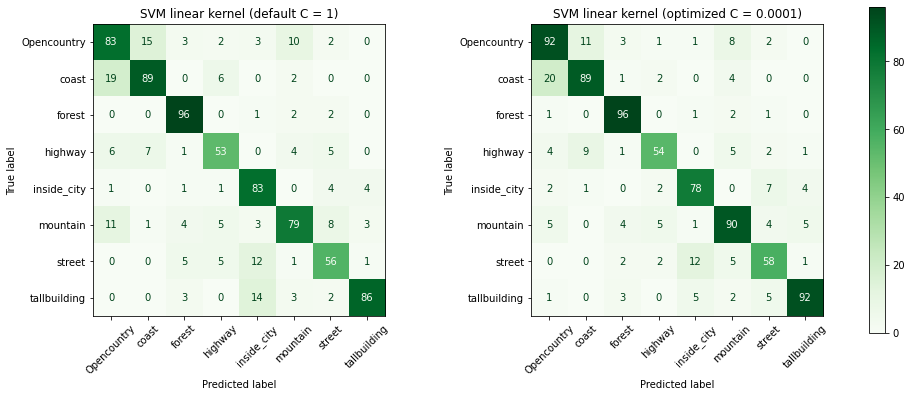

In [ ]:
lin_svm_stsc_def = SVC(C = 1, kernel = 'linear')
lin_svm_stsc_def.fit(visual_words_stsc, train_labels)

classifiers = {'SVM linear kernel (default C = 1)': lin_svm_stsc_def, 'SVM linear kernel (optimized C = 0.0001)': lin_svm_stsc_opt}

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for i, (key, classifier) in enumerate(classifiers.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
      classifier,
      visual_words_test_stsc,
      test_labels,
      display_labels = classes,
      cmap = plt.cm.Greens,
      normalize = None,
      ax=axs[i],
      xticks_rotation=45
    )
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()

fig.colorbar(disp.im_, ax=axs)

It can be observed how the correct classifications have generally increased after optimizing the regularization term (inside city images being the only exception). The most common misclassifications are between images belonging to the open country and coast classes, such as the ones displayed below:

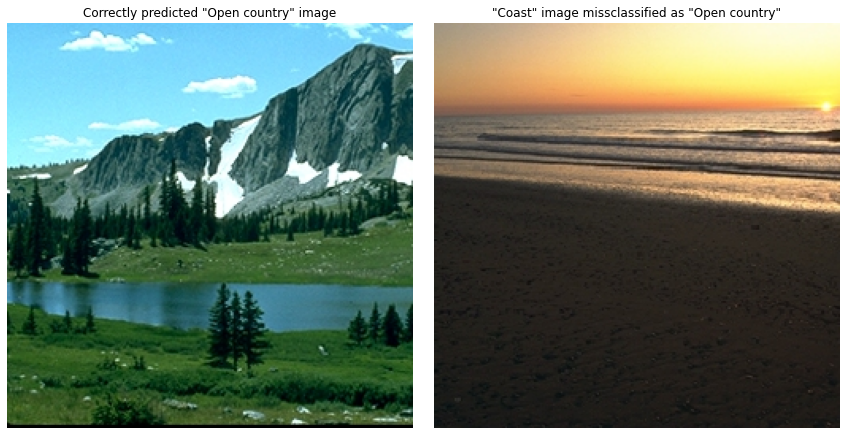

In [ ]:
for i, pred in enumerate(lin_svm_stsc_def.predict(visual_words_test_stsc)):
  if pred == 'Opencountry' and test_labels[i] == 'coast':
    img_index_miss = i
  elif pred == 'Opencountry' and test_labels[i] == 'Opencountry':
    img_index_right = i

fil_right = test_images_filenames[img_index_right]
img_right = cv2.imread(fil_right)
imgRGB_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

fil_miss = test_images_filenames[img_index_miss]
img_miss = cv2.imread(fil_miss)
imgRGB_miss = cv2.cvtColor(img_miss, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,2, figsize=(12,6))
titles = ['Correctly predicted "Open country" image', '"Coast" image missclassified as "Open country"']
images = [imgRGB_right, imgRGB_miss]
for ax, image, title in zip(axes.flatten(), images, titles):
  ax.imshow(image)
  ax.set_title(title)
  ax.axis('off')
plt.tight_layout()
plt.show()

While images like the two shown above seem to be very different, it makes sense for open country and coast images to in some cases get their classes mixed up. These two classes contain the images with the widest spaces, and tend to have many elements in common such as open skies, clouds, water, etc.

### **4.2. SVM with RBF Kernel**
Next, a preliminary SVM using a **RBF kernel** and a default regularization of *C = 1* and a gamma set to *scale* is built and tested. As detailed in the sklearn's documentation, this *scale* setting uses a gamma determined by: 1 / (n_features * X.var()). The same range of scales for the dense SIFT as in the previous section is considered.

In [ ]:
accuracies_rbf_woutnorm = accuracies_rt_scales(kernel = 'rbf', C = 1, gamma = 'scale')

for i in range(len(scales)):
  print(f'Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: {scales[i]} (No normalization): {accuracies_rbf_woutnorm[i]}')

Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 2 (No normalization): 77.32342007434944
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 3 (No normalization): 78.93432465923172
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 4 (No normalization): 80.545229244114
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 5 (No normalization): 80.66914498141264
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 6 (No normalization): 82.65179677819083
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 7 (No normalization): 82.15613382899627
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 8 (No normalization): 82.5278810408922
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 9 (No normalization): 82.77571251548946


Once again, the SVM classifier with this new RBF kernel appears to deliver good accuracies out-of-the-box. Descriptors computed with a dense SIFT of scale 6 or higher seem to lead to the highest accuracy ratings.

The effect of applying normalization and standard scaling to the descriptors on the classifier's performance is also tested.

In [ ]:
accuracies_rbf_l2 = accuracies_rt_scales(kernel = 'rbf', C = 1, gamma = 'scale', norm = 'l2')

for i in range(len(scales)):
  print(f'Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: {scales[i]} (L2 normalization): {accuracies_rbf_l2[i]}')

Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 2 (L2 normalization): 77.69516728624535
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 3 (L2 normalization): 78.93432465923172
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 4 (L2 normalization): 81.66047087980174
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 5 (L2 normalization): 80.545229244114
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 6 (L2 normalization): 82.77571251548946
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 7 (L2 normalization): 83.27137546468401
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 8 (L2 normalization): 82.8996282527881
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 9 (L2 normalization): 83.14745972738538


In [ ]:
accuracies_rbf_stsc = accuracies_rt_scales(kernel = 'rbf', C = 1, gamma = 'scale', norm = 'stsc')

for i in range(len(scales)):
  print(f'Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: {scales[i]} (Standard scaling): {accuracies_rbf_stsc[i]}')

Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 2 (Standard scaling): 78.06691449814126
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 3 (Standard scaling): 79.67781908302355
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 4 (Standard scaling): 79.05824039653035
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 5 (Standard scaling): 81.66047087980174
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 6 (Standard scaling): 80.66914498141264
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 7 (Standard scaling): 81.66047087980174
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 8 (Standard scaling): 80.66914498141264
Accuracy SVM with RBF kernel for C=1 and gamma="scale", scale: 9 (Standard scaling): 81.16480793060718


The previous accuracy results for different scales and types of normalizations can be visualized in the line plot below.

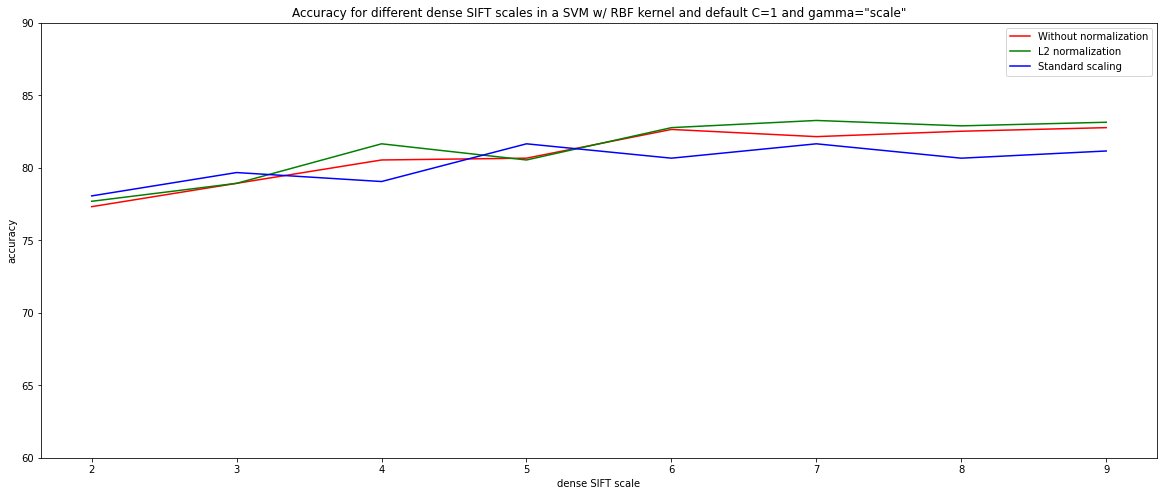

In [ ]:
scales_list = list(scales)
plt.title('Accuracy for different dense SIFT scales in a SVM w/ RBF kernel and default C=1 and gamma="scale"')
plt.plot(scales_list, accuracies_rbf_woutnorm, 'r', label='Without normalization')
plt.plot(scales_list, accuracies_rbf_l2, 'g', label='L2 normalization')
plt.plot(scales_list, accuracies_rbf_stsc, 'b', label='Standard scaling')
plt.xlabel('dense SIFT scale')
plt.ylabel('accuracy')
plt.ylim([60, 90])
plt.legend()

plt.show()

Again, the application of normalization and standard scaling on the descriptors does not seem to lead to any significant changes in accuracy. There is a slight increase in performance as the scale considered in the dense SIFT grows, but this increase seems to stop at a scale of 6. Just like in the previous section, this scale is fixed at 6 and standard scaling is used in the next tests.

Similarly to the process done for the SVM with a linear kernel, (5-fold) cross-validation and a grid search are performed to optimize the regularization and kernel coefficient (gamma) terms shown in the *param_grid* below in an attempt to maximize the classifiers accuracy.

In [ ]:
param_grid = [
  {'C': [0.00001, 0.0001, 0.001, 0.01, 0.5, 1.0, 10, 100],
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001]}
]

In [ ]:
dense_descriptors, dense_t_descriptors = load_dense_descriptors(6, step, 'train')
dense_descriptors_stsc, dense_t_descriptors_stsc = stsc(dense_descriptors, dense_t_descriptors)
codebook_stsc = kmean_clustering(dense_descriptors_stsc, K)
visual_words_stsc = compute_visual_words(dense_t_descriptors_stsc, K, codebook_stsc)

optim_param_path = base_path + f'optimal_param_rbf_stsc_6_{step}.pkl'

if os.path.exists(optim_param_path):
    with open(optim_param_path, 'rb') as reader:
        optim_param = pickle.load(reader)
else:
    optim_param = GridSearchCV(
        SVC(kernel='rbf'),
        param_grid,
        cv=5,
        scoring='accuracy'
    )
    optim_param.fit(visual_words_stsc, train_labels)
    with open(optim_param_path, 'wb') as handle:
        pickle.dump(optim_param, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f'Best parameters: {optim_param.best_params_}')

Best parameters: {'C': 1.0, 'gamma': 'scale'}


The optimal parameters according to the grid search are a regularization term of *C = 1* and a gamma set to *scale*, which happen to be the default values that have already been tested.

The average score of the conducted cross-validation is computed.



In [ ]:
print(f'Average score of Cross-validation folds: {optim_param.best_score_*100}')

Average score of Cross-validation folds: 78.41554263784639


Below is a confusion matrix reflecting the classification results for these parameters.

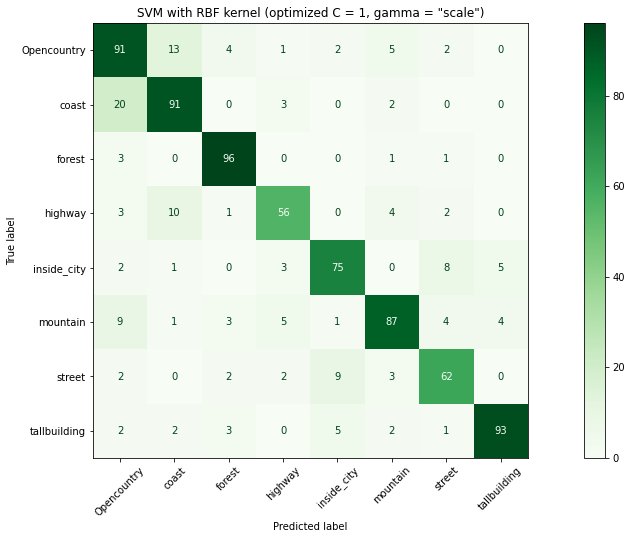

In [ ]:
rbf_svm_stsc_opt = SVC(C = 1, gamma = 'scale', kernel = 'rbf')
rbf_svm_stsc_opt.fit(visual_words_stsc, train_labels)

disp = ConfusionMatrixDisplay.from_estimator(
      rbf_svm_stsc_opt,
      visual_words_test_stsc,
      test_labels,
      display_labels = classes,
      cmap = plt.cm.Greens,
      normalize = None,
      xticks_rotation=45
    )
disp.ax_.set_title('SVM with RBF kernel (optimized C = 1, gamma = "scale")')

fig.colorbar(disp.im_, ax=axs)

Just like for the SVM with a linear kernel, most misclassifications happen with open country images being predicted to be coast images and viceversa.

### **4.3 SVM with Histogram Intersection Kernel**
A home-made **histogram intersection kernel** is also to be tested for the SVM classifier. 

A function to compute the histogrtam intersection kernel is created as displayed in the cell below. This function checks the overlap between the histograms from two different images.

In [23]:
def histogramIntersection(M, N):
    m = M.shape[0]
    n = N.shape[0]
    K_int = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            temp = np.sum(np.minimum(M[i], N[j]))
            K_int[i][j] = temp
    return K_int

A preliminary SVM using a the specified kernel and a default regularization of *C = 1* is built and tested. The same range of scales for the dense SIFT as in the previous sections is considered.

In [ ]:
accuracies_hint_woutnorm = accuracies_rt_scales(kernel = histogramIntersection, C = 1, hint = True)

for i in range(len(scales)):
  print(f'Accuracy SVM with Histogram intersection kernel for C=1, scale: {scales[i]} (No normalization): {accuracies_hint_woutnorm[i]}')

Accuracy SVM with Histogram intersection kernel for C=1, scale: 2 (No normalization): 79.67781908302355
Accuracy SVM with Histogram intersection kernel for C=1, scale: 3 (No normalization): 81.5365551425031
Accuracy SVM with Histogram intersection kernel for C=1, scale: 4 (No normalization): 81.90830235439901
Accuracy SVM with Histogram intersection kernel for C=1, scale: 5 (No normalization): 83.64312267657994
Accuracy SVM with Histogram intersection kernel for C=1, scale: 6 (No normalization): 84.51053283767038
Accuracy SVM with Histogram intersection kernel for C=1, scale: 7 (No normalization): 82.8996282527881
Accuracy SVM with Histogram intersection kernel for C=1, scale: 8 (No normalization): 83.27137546468401
Accuracy SVM with Histogram intersection kernel for C=1, scale: 9 (No normalization): 82.15613382899627


The SVM classifier using a histogram intersection kernel yet again delivers a good accuracy without prior adjustments. This accuracy is actually the highest one so far, despite not having carried out an optimization of any parameters. This kernel however requires a significantly longer computation time compared to the prior ones.

The effect of applying normalization and standard scaling to the descriptors on the classifier's performance is also tested.

In [ ]:
accuracies_hint_l2 = accuracies_rt_scales(kernel = histogramIntersection, C = 1, norm = 'l2', hint = True)

for i in range(len(scales)):
  print(f'Accuracy SVM with Histogram intersection kernel for C=1, scale: {scales[i]} (L2 normalization): {accuracies_hint_l2[i]}')

Accuracy SVM with Histogram intersection kernel for C=1, scale: 2 (L2 normalization): 78.56257744733581
Accuracy SVM with Histogram intersection kernel for C=1, scale: 3 (L2 normalization): 80.545229244114
Accuracy SVM with Histogram intersection kernel for C=1, scale: 4 (L2 normalization): 81.66047087980174
Accuracy SVM with Histogram intersection kernel for C=1, scale: 5 (L2 normalization): 81.04089219330855
Accuracy SVM with Histogram intersection kernel for C=1, scale: 6 (L2 normalization): 82.03221809169764
Accuracy SVM with Histogram intersection kernel for C=1, scale: 7 (L2 normalization): 82.65179677819083
Accuracy SVM with Histogram intersection kernel for C=1, scale: 8 (L2 normalization): 82.77571251548946
Accuracy SVM with Histogram intersection kernel for C=1, scale: 9 (L2 normalization): 80.42131350681537


In [ ]:
accuracies_hint_stsc = accuracies_rt_scales(kernel = histogramIntersection, C = 1, norm = 'stsc', hint = True)

for i in range(len(scales)):
  print(f'Accuracy SVM with Histogram intersection kernel for C=1, scale: {scales[i]} (Standard scaling): {accuracies_hint_stsc[i]}')

Accuracy SVM with Histogram intersection kernel for C=1, scale: 2 (Standard scaling): 79.42998760842627
Accuracy SVM with Histogram intersection kernel for C=1, scale: 3 (Standard scaling): 79.42998760842627
Accuracy SVM with Histogram intersection kernel for C=1, scale: 4 (Standard scaling): 81.90830235439901
Accuracy SVM with Histogram intersection kernel for C=1, scale: 5 (Standard scaling): 79.42998760842627
Accuracy SVM with Histogram intersection kernel for C=1, scale: 6 (Standard scaling): 80.545229244114
Accuracy SVM with Histogram intersection kernel for C=1, scale: 7 (Standard scaling): 83.02354399008675
Accuracy SVM with Histogram intersection kernel for C=1, scale: 8 (Standard scaling): 79.92565055762083
Accuracy SVM with Histogram intersection kernel for C=1, scale: 9 (Standard scaling): 80.66914498141264


The previous accuracy results for different scales and types of normalizations can be visualized in the line plot below.

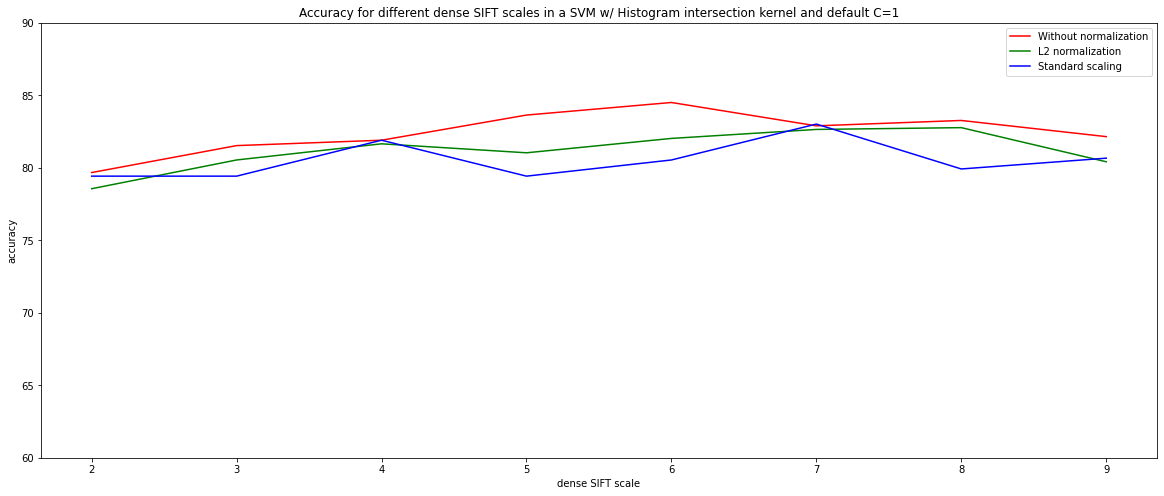

In [ ]:
scales_list = list(scales)
plt.title('Accuracy for different dense SIFT scales in a SVM w/ Histogram intersection kernel and default C=1')
plt.plot(scales_list, accuracies_hint_woutnorm, 'r', label='Without normalization')
plt.plot(scales_list, accuracies_hint_l2, 'g', label='L2 normalization')
plt.plot(scales_list, accuracies_hint_stsc, 'b', label='Standard scaling')
plt.xlabel('dense SIFT scale')
plt.ylabel('accuracy')
plt.ylim([60, 90])
plt.legend()

plt.show()

Normalization and standard scaling still do not seem to affect the classifiers accuracy much at all. Just as with the other kernels, there is a slight increase in performance as the scale grows, but this increase appears to stop at a scale of 6. That being said, this scale for the dense SIFT is yet again fixed at 6, and standard scaling is used in the following tests.

(5-fold) cross-validation and a grid search are again performed to optimize the regularization term shown in the *param_grid* below.

In [ ]:
param_grid = [
  {'C': [0.00001, 0.0001, 0.001, 0.01, 0.5, 1.0, 10, 100]}
]

In [ ]:
dense_descriptors, dense_t_descriptors = load_dense_descriptors(6, step, 'train')
dense_descriptors_stsc, dense_t_descriptors_stsc = stsc(dense_descriptors, dense_t_descriptors)
codebook_stsc = kmean_clustering(dense_descriptors_stsc, K)
visual_words_stsc = compute_visual_words(dense_t_descriptors_stsc, K, codebook_stsc)

optim_param_path = base_path + f'optimal_param_hint_stsc_6_{step}.pkl'

if os.path.exists(optim_param_path):
    with open(optim_param_path, 'rb') as reader:
        optim_param = pickle.load(reader)
else:
    optim_param = GridSearchCV(
        SVC(kernel=histogramIntersection),
        param_grid,
        cv=5,
        scoring='accuracy'
    )
    optim_param.fit(visual_words_stsc, train_labels)
    with open(optim_param_path, 'wb') as handle:
        pickle.dump(optim_param, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f'Best parameters: {optim_param.best_params_}')

Best parameters: {'C': 0.001}


The optimal regularization term turns out to be *C = 0.001*. The accuracy of the classifier is thus recalculated for this new adjusted *C*, and the average score of the cross-validation is also computed.

In [ ]:
hint_svm_stsc_opt = SVC(C = 0.001, kernel = histogramIntersection)
hint_svm_stsc_opt.fit(visual_words_stsc, train_labels)

dense_test_descriptors, dense_test_t_descriptors = load_dense_descriptors(6, step, 'test')
dense_test_descriptors_stsc, dense_test_t_descriptors_stsc = stsc(dense_test_descriptors, dense_test_t_descriptors)
visual_words_test_stsc = compute_visual_words(dense_test_t_descriptors_stsc, K, codebook_stsc)

acc = compute_accuracy(visual_words_test_stsc, hint_svm_stsc_opt)
print(f'Accuracy of SVM with Histogram intersection kernel (C = 0.001) (Standard Scaling): {acc}')

print(f'Average score of Cross-validation folds: {optim_param.best_score_*100}')

Accuracy of SVM with Histogram intersection kernel (C = 0.001) (Standard Scaling): 81.16480793060718
Average score of Cross-validation folds: 79.42519329533269


By having utilized an optimal regularization value, the accuracy of the SVM classifier with a linear kernel has increased by less than 1%. Below are the confusion matrices for the default classifier (*C = 1*) and the optimized one (*C = 0.001*).

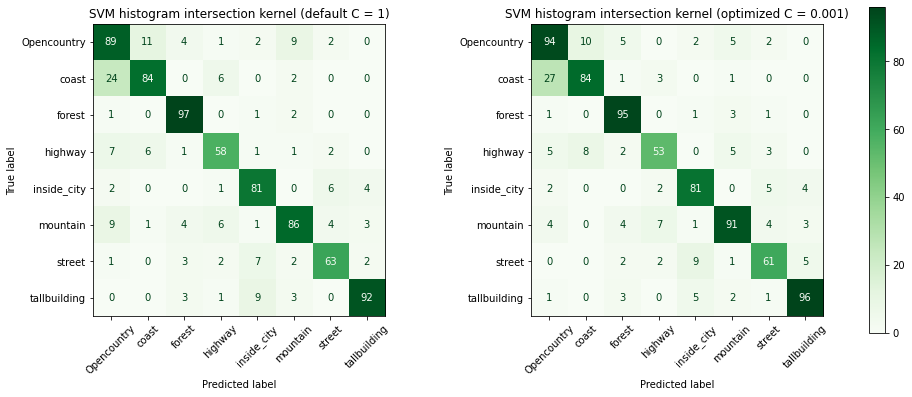

In [ ]:
hint_svm_stsc_def = SVC(C = 1, kernel = histogramIntersection)
hint_svm_stsc_def.fit(visual_words_stsc, train_labels)

classifiers = {'SVM histogram intersection kernel (default C = 1)': hint_svm_stsc_def, 'SVM histogram intersection kernel (optimized C = 0.001)': hint_svm_stsc_opt}

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for i, (key, classifier) in enumerate(classifiers.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
      classifier,
      visual_words_test_stsc,
      test_labels,
      display_labels = classes,
      cmap = plt.cm.Greens,
      normalize = None,
      ax=axs[i],
      xticks_rotation=45
    )
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()

fig.colorbar(disp.im_, ax=axs)

While the performance of the SVM with the histogram intersection kernel is the best so far, the misclassifications present in the results above are still in line with those in prior classifiers. Most errors yet again happen between the open country and coast classes.

## **5. Spatial Pyramids**
Until now every image has been assigned one word histogram. The use of **spatial pyramids** is proposed to divide images into different segments and represent each of these with a histogram. This should provide additional information of each image, as location-related characteristics now come into play.

The idea is to split images only into **horizontal blocks** (see second image below) instead of splitting them both horizontally and vertically (as in the third image below). The reason behind this is how landscapes tend to be more consistent in the horizontal direction. For instance, ground or water will always be covering the entirety of the width of an image's low portion. On the other hand, one cannot predict what the horizontal position of elements such as trees will be in a given image. That being said, images split into simple horizontal blocks should encompass nearly the same amount of information as images split in more complex grid-like patterns.

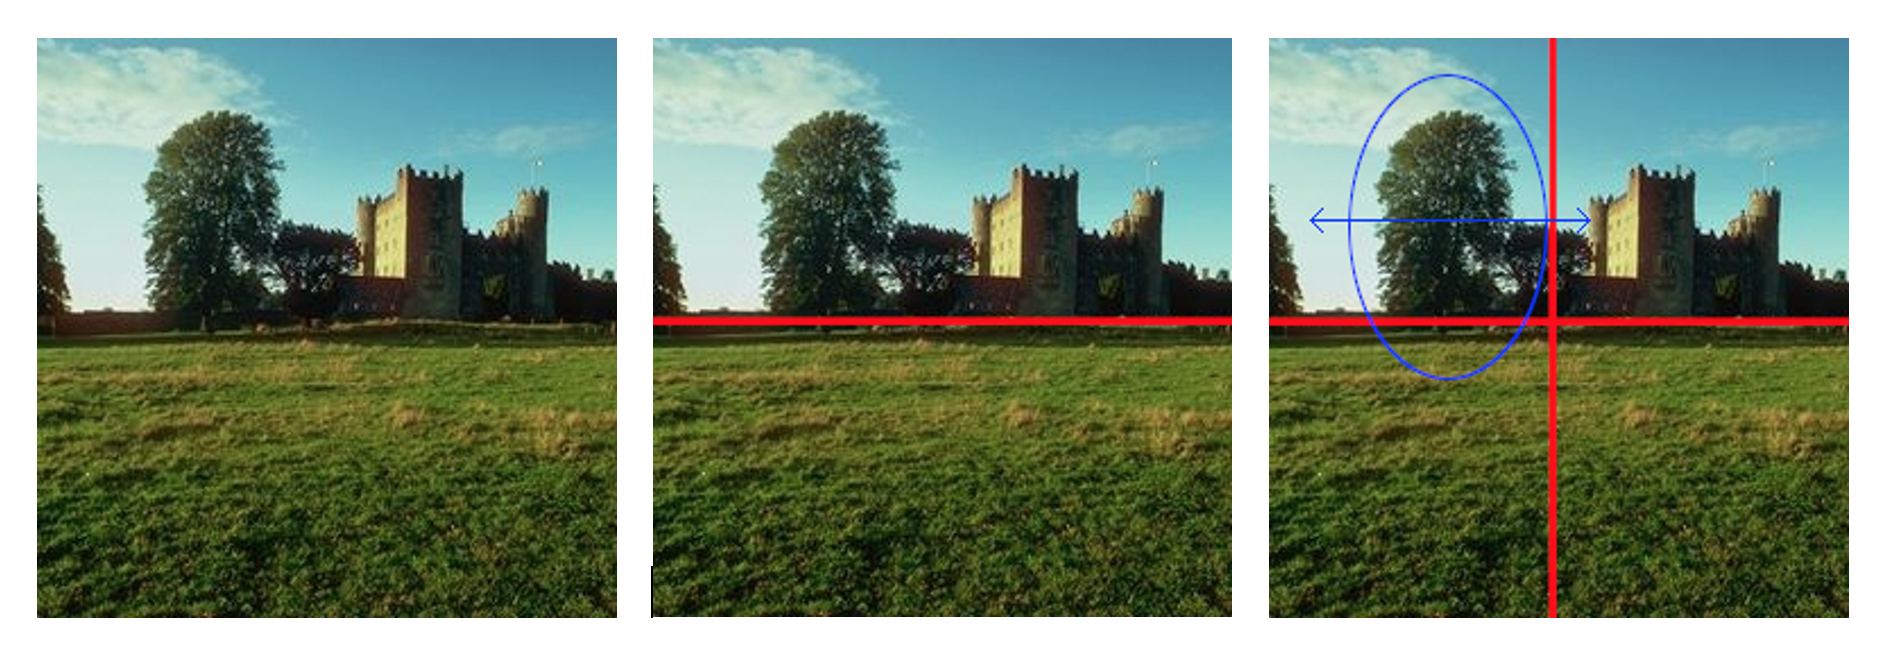

Note that the examples portrayed above are only for a 1-level approach. Further splits can be performed for higher level pyramids.

A function to compute the visual words of a set of training or test images following a spatial pyramid approach is built. This function is thus among other arguments provided with a number of levels to be considered, and iterates through each level performing the appropriate horizontal splits and computing histograms for each of these. Histograms from different levels are assigned particular importances through the use of weights.

In [28]:
def compute_spatial_pyramid(level, codebook, K, scale, step, kind):
    visual_words = []

    if kind == 'train':
      filenames = train_images_filenames
      labels = train_labels
    elif kind == 'test':
      filenames = test_images_filenames
      labels = test_labels

    for filename in (filenames):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        image_kpts = []
        histograms = []
      
        for l in range(level+1):
          split_h = int(np.ceil(gray.shape[0] / (l+1)))
          for h in range(0, gray.shape[0], split_h):
              t_descriptors = []
              block = gray[h : h+split_h, :]

              for x in range(scale // 2, block.shape[0], scale+step):
                  for y in range(scale // 2, gray.shape[1], scale+step):
                      image_kpts.append(cv2.KeyPoint(x,y,float(scale)))
         
              kpts, split_des = cv2.SIFT_create().compute(block, image_kpts)
          
              hist = compute_visual_words([split_des], K, codebook)
              hist = hist.ravel()
              weight = 2 ** (-(level - l))
              histograms.append(weight * hist)
            
        visual_word = np.array(histograms).ravel()
        dev = np.std(visual_word)
        visual_word -= np.mean(visual_word)
        visual_word /= dev
        visual_words.append(visual_word)
    return visual_words

Another function is also created to determine if there are existing visual words that can be loaded or if the previous function needs to be called.

In [29]:
def load_spatial_pyramid(level, codebook, K, scale, step, kind = 'train'):
    if kind == 'train':
      spatial_pyramid_path = base_path + f'SIFT_{kind}_spatial_pyramid_visual_words-{level}-{scale}-{step}.pkl'
    elif kind == 'test':
      spatial_pyramid_path = base_path + f'SIFT_{kind}_spatial_pyramid_visual_words-{level}-{scale}-{step}.pkl'

    if os.path.exists(spatial_pyramid_path):
        with open(spatial_pyramid_path, 'rb') as reader:
            visual_words = pickle.load(reader)
    else:
        print('Computing visual words...')
        visual_words = compute_spatial_pyramid(level, codebook, K, scale, step, kind)
        print('Visual words computed!')

        with open(spatial_pyramid_path, 'wb') as handle:
            pickle.dump(visual_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return visual_words

The effects of using spatial pyramids is evaluated on an SVM classifier with a linear kernel built on dense SIFT descriptors with a scale of 6 as in prior sections. The performance of the classifier for levels from 0 to 3 is evaluated. The regularization term is optimized for each level using the (5-fold) cross-validation and a grid search approach.

In [ ]:
levels = [0, 1, 2, 3]

param_grid = [
  {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10, 100]}
]

In [ ]:
dense_descriptors, dense_t_descriptors = load_dense_descriptors(6, 5, 'train')
codebook = kmean_clustering(dense_descriptors, K)

accuracies = []

for level in levels:
  visual_words_pyramids = load_spatial_pyramid(level, codebook, K, 6, 5, 'train')

  optim_param = GridSearchCV(
        SVC(kernel= 'linear'),
        param_grid,
        cv=5,
        scoring='accuracy'
  )
  optim_param.fit(visual_words_pyramids, train_labels)

  visual_words_test_pyramids = load_spatial_pyramid(level, codebook, K, 6, 5, 'test')

  acc = compute_accuracy(visual_words_test_pyramids, optim_param)
  print(f'Accuracy of SVM with linear kernel (Level {level} Spatial Pyramid): {acc}')

  accuracies.append(acc)

Accuracy of SVM with linear kernel (Level 0 Spatial Pyramid): 82.5278810408922
Accuracy of SVM with linear kernel (Level 1 Spatial Pyramid): 83.39529120198264
Accuracy of SVM with linear kernel (Level 2 Spatial Pyramid): 84.2627013630731
Accuracy of SVM with linear kernel (Level 3 Spatial Pyramid): 80.545229244114


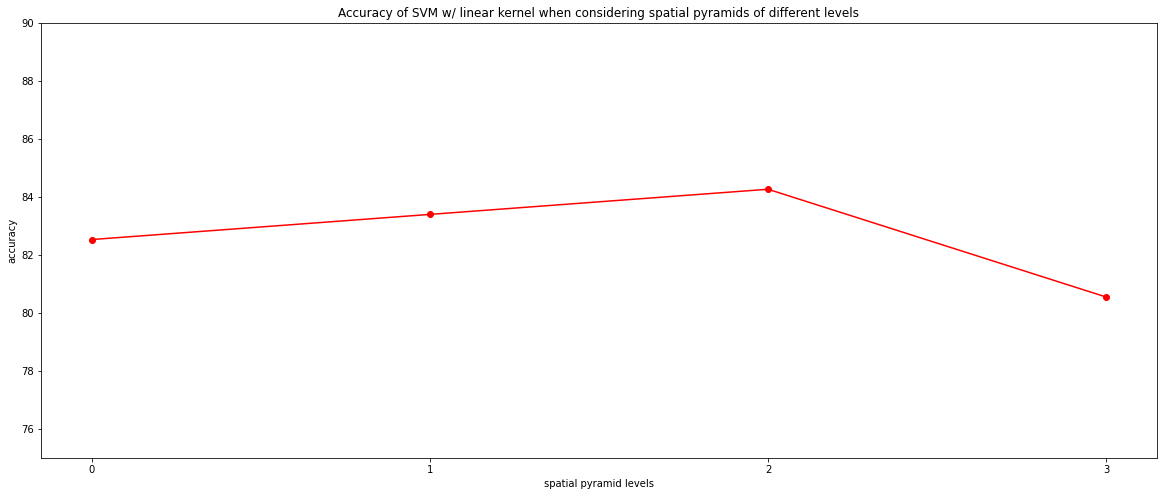

In [ ]:
plt.title('Accuracy of SVM w/ linear kernel when considering spatial pyramids of different levels')
plt.plot(levels, accuracies, 'r', marker='o')
plt.xlabel('spatial pyramid levels')
plt.xticks([0, 1, 2, 3])
plt.ylabel('accuracy')
plt.ylim([75, 90])

plt.show()

Spatial pyramids set to certain levels indeed appear to slightly increase the accuracy scores of the SVM classifier. A 2-level spatial pyramid leads to the best results, while at level 3 the performance starts decreasing.

## **6. Fisher Vectors [Extra]**
**Fisher Vectors**, an alternative but very similar method to the BoVW approach used until now is explored next. This method also consists in extracting features from images and building a vocabulary, but unlike standard BoVW, it takes into consideration additional aspects such as the distance of descriptors to their closest words. It does so by using a Gaussian Mixture Model (GMM) instead of k-means to construct the vocabulary and then relies on soft assignments.

A function is first created to compute a fisher vector given a descriptor and a GMM model.

In [18]:
def fisher_vector(xx, gmm):
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    Q = gmm.predict_proba(xx)

    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

Another function is prepared that takes in a number of clusters to be considered for the GMM, a number of components to carry out a PCA dimensionality reduction and the training & testing descriptors. It then returns the fisher vectors for the inputed descriptors. It is worth noting that for simplicity reasons, the function operates on a specified sample of the total data.

In [19]:
def get_fisher_vectors(num_clusters_gmm, num_components_pca, train_descriptors, test_descriptors):    
    D = np.vstack(train_descriptors)
    indices = random.sample(range(0,D.shape[0]), num_clusters_gmm*1000)
    sample = D[indices,:]
    
    pca = PCA(n_components=num_components_pca)
    samplepca = pca.fit_transform(sample)
    
    gmm = GaussianMixture(n_components=num_clusters_gmm, covariance_type='diag')
    gmm.fit(samplepca)
    
    train_descriptors_fisher = []
    for train_descriptor in tqdm(train_descriptors):
        start = 0
        length = train_descriptor.shape[0]
        stop = start + length
        train_descriptor_pca = train_descriptor[:,:num_components_pca]
        start = stop
        train_descriptor_fisher = fisher_vector(train_descriptor_pca, gmm)
        train_descriptors_fisher.append(train_descriptor_fisher)
        
    Dtest = np.vstack(test_descriptors)
    test_descriptors_fisher = []
    for test_descriptor in tqdm(test_descriptors):
        start = 0
        length = test_descriptor.shape[0]
        stop = start + length
        test_descriptor_pca = test_descriptor[:, :num_components_pca]
        start = stop
        test_descriptor_fisher = fisher_vector(test_descriptor_pca, gmm)
        test_descriptors_fisher.append(test_descriptor_fisher)
        
    def normalize_fisher(descriptors):
        image_fvs = np.vstack(descriptors)
        image_fvs = np.sign(image_fvs) * np.abs(image_fvs) ** 0.5
        norms = np.sqrt(np.sum(image_fvs ** 2, 1))
        image_fvs /= norms.reshape(-1, 1)
        return image_fvs

    train_fisher = normalize_fisher(train_descriptors_fisher)
    test_fisher = normalize_fisher(test_descriptors_fisher)
    return train_fisher, test_fisher

The presented functions are now tested for descriptors from the previously addressed scale 6 dense SIFT and a SVM classifier with a histogram intersection kernel. The number of clusters for the GMM is set to 16, and the number of components for the PCA to 32.

In [20]:
dense_descriptors, dense_train_descriptors = load_dense_descriptors(6, step, 'train')
dense_test_descriptors, dense_test_t_descriptors = load_dense_descriptors(6, step, 'test')
train_f, test_f = get_fisher_vectors(16, 32, dense_train_descriptors, dense_test_t_descriptors)

  0%|          | 0/1881 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

(5-fold) cross-validation in a grid search is yet again used to determine the optimal regularization term from the options shown in the *param_grid* below.

In [21]:
param_grid = [
  {'C': [0.00001, 0.0001, 0.001, 0.01, 0.5, 1.0, 10, 100]}
]

In [24]:
optim_param_path = base_path + f'optimal_param_hint_FV_6_{step}.pkl'

if os.path.exists(optim_param_path):
    with open(optim_param_path, 'rb') as reader:
        optim_param = pickle.load(reader)
else:
    optim_param = GridSearchCV(
      SVC(kernel=histogramIntersection),
      param_grid,
      cv=5,
      scoring='accuracy'
    )
    optim_param.fit(train_f, train_labels)
    with open(optim_param_path, 'wb') as handle:
        pickle.dump(optim_param, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(optim_param.best_params_)

{'C': 1.0}


This optimal value appears to be of *C=1*. The accuracy of the SVM classifier using Fisher Vectors is evaluated for this value, as well as the average score from all cross-validation folds.

In [26]:
acc = 100*optim_param.score(test_f, test_labels)
print(f'Accuracy of SVM with Histogram intersection kernel (C=1) using Fisher Vectors: {acc}')

print(f'Average score of Cross-validation folds: {optim_param.best_score_*100}')

Accuracy of SVM with Histogram intersection kernel (C=1) using Fisher Vectors: 27.137546468401485
Average score of Cross-validation folds: 81.71285061233704


The accuracy rating of the SVM classifier after having implemented Fisher Vectors is the best one so far, despite the use of PCA dimensionality reduction. This comes to show the added benefits of soft asignation compared to the k-means approach.

## **7. General Conclusions**
*   SVM classification can be considered a good alternative to k-NN, and probably a better one for the case at hand. It delivers great accuracy ratings without the need for carefully tuning parameters, and does not require long computation times.

*   Despite generally performing well straight away, finding optimal values for the regularization term (and the kernel coefficient when using the RBF kernel) can lead to a significant increase in classification accuracy. Finding these optimal parameters ussing k-fold cross validation is important so that consistency throughout all of the available data is ensured.

*   Using an histogram intersection kernel for the SVM classifier led to better results than for the linear and RBF kernels, but also demanded significantly longer computation times. This kind of kernel is probably better than the other two for this particular case since the overlap of histograms is more representative of image similarity than the distances among features and their positioning.

*   While the scale used for the descriptors taken from a dense SIFT does matter, it does not seem like it has a great effect on the accuracy of the SVM classifiers. Performance appeared to slightly increase up to a scale of 6, but from that point remained quite consistent.

*   The normalization and standard scaling of descriptors does not seem to have much of an effect on the accuracy of the SVM classifiers for the addressed image data. We believe this has to do with the fact images are already in a similar scale.

*   It has been confirmed how spatial pyramids can increase the accuracy of a classifier even if by a minimal extent by providing additional information in terms of descriptor location. Splitting images into horizontal blocks has proven to be an effective approach.

*   Fisher Vectors can be considered to be an extension to the BoVW approach, going beyond the "hard" assignment of features to words. By building a vocabulary with a GMM, features can be associated to a likelihood of belonging to a certain class rather than just being associated to said class right away.

